In [10]:
import numpy as np
import h5py
import healpy as hp
from scipy.stats import norm
from bilby.core.prior import Cosine, Uniform, PowerLaw
import scipy.stats as ss

#Global Imports
import matplotlib 
%matplotlib inline
import pickle

import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex']= False
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')


In [11]:
# Global Imports
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import fmin
from scipy.interpolate import splev, splrep, interp1d
from scipy.stats import gaussian_kde, norm
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import leastsq
from ligo.skymap.kde import Clustered3DSkyKDE, ClusteredKDE

class confidence_interval(object):
    def __init__(self, posterior, x, level=0.683, verbose=False):
        self.posterior = posterior
        self.x = x
        self.level = level
        self.verbose = verbose
        self.lower_level, self.upper_level = self.HDI()
        self.interval = self.upper_level - self.lower_level
        self.map = self.MAP()
        
    def HDI(self):
        cdfvals = cumtrapz(self.posterior, self.x)
        sel = cdfvals > 0.
        xx = self.x[1:][sel]
        cdfvals = cdfvals[sel]
        ppf = interp1d(cdfvals, xx, fill_value=0., bounds_error=False)

        def intervalWidth(lowTailPr):
            ret = ppf(self.level + lowTailPr) - ppf(lowTailPr)
            if (ret > 0.):
                return ret
            else:
                return 1e4
        HDI_lowTailPr = fmin(intervalWidth, 1. - self.level, disp=self.verbose)[0]
        return ppf(HDI_lowTailPr), ppf(HDI_lowTailPr + self.level)


    def MAP(self):
        sp = UnivariateSpline(self.x, self.posterior, s=0.)
        x_highres = np.linspace(self.x[0], self.x[-1], 100000)
        y_highres = sp(x_highres)
        return x_highres[np.argmax(y_highres)]


In [12]:
from astropy.cosmology import Planck15
import astropy.units as u
import astropy.constants as constants
from scipy.interpolate import interp1d
from ligo.skymap.distance import parameters_to_moments
from ligo.skymap.io import fits


zs = np.linspace(0, 1, 10000)
dLs = Planck15.luminosity_distance(zs).to(u.Mpc).value    
z_at_dL = interp1d(dLs,zs)
dL_at_z = interp1d(zs,dLs)


r = np.linspace(100, 10000, 1000)
ra_c = 192.4262500*np.pi/180
dec_c = 34.8247222*np.pi/180
theta = 0.5 * np.pi - np.deg2rad(dec_c)
phi = np.deg2rad(ra_c)

z = 0.438
dl = dL_at_z(z)




In [17]:
with h5py.File('GW190521_posterior_samples.h5', 'r') as f:
    print(list(f.keys()))
    samples = np.array(f['IMRPhenomPv3HM/posterior_samples'])

['IMRPhenomPv3HM', 'NRSur7dq4', 'SEOBNRv4PHM', 'history', 'version']


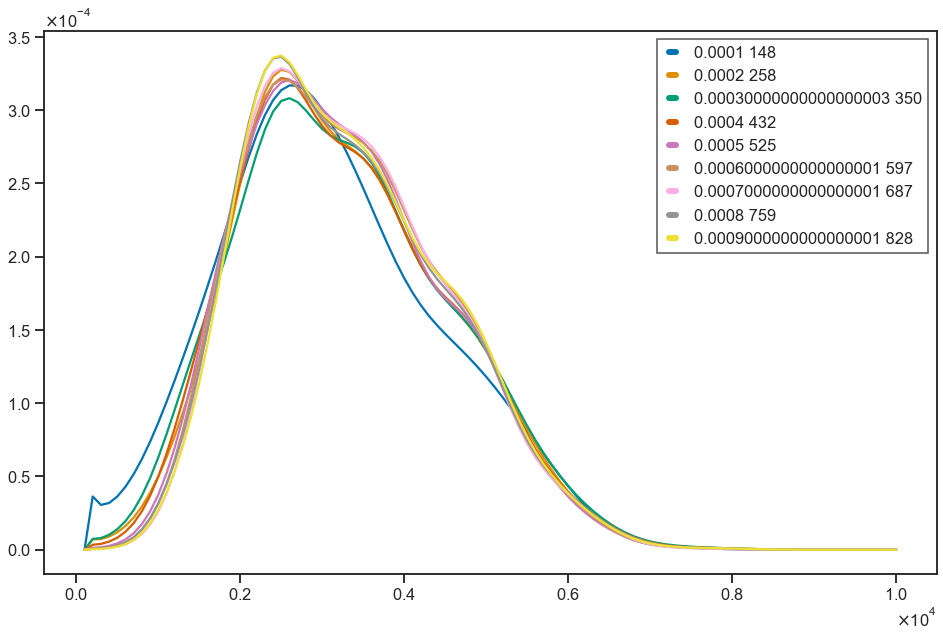

In [18]:
for r in np.arange(0.0001,.001,.0001):
    ds=np.linspace(100,10000,100)
    
    sel = np.where(np.abs(samples['ra']-ra_c)*np.abs(np.sin(samples['dec'])-np.sin(dec_c))<=r)[0]
    k = ss.gaussian_kde(samples['luminosity_distance'][sel])
    ps = (k(ds) + k(-ds))/(ds*ds) # Reflect about d = 0 boundary
    ps[0] = 0.0 # Singularity at d = 0
    pps = ps / np.trapz(ps, ds)
    plt.plot(ds, pps,label=str(r)+' '+str(len(sel)))

plt.legend()

In [ ]:
np.pi*4*

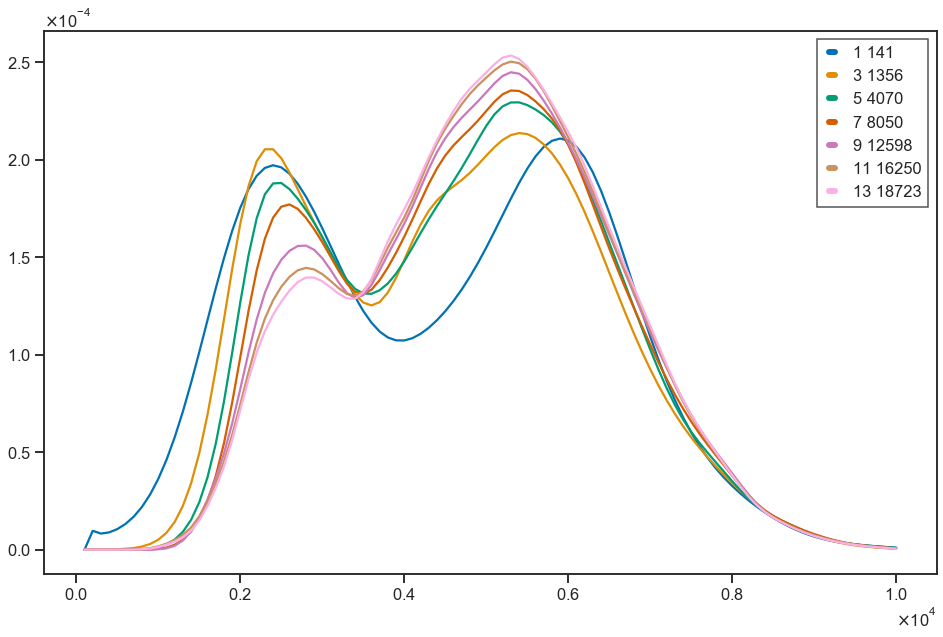

In [30]:
for r in np.arange(1,15,2):
    ds=np.linspace(100,10000,100)
    sel = np.where(np.sqrt(np.square((ra_c - samples['ra'])*np.cos(dec_c)) + np.square((dec_c - samples['dec']))) < r*np.pi/180.0)[0]
    k = ss.gaussian_kde(samples['luminosity_distance'][sel])
    ps = (k(ds) + k(-ds))/(ds*ds) # Reflect about d = 0 boundary
    ps[0] = 0.0 # Singularity at d = 0
    pps = ps / np.trapz(ps, ds)
    plt.plot(ds, pps,label=str(r)+' '+str(len(sel)))

plt.legend()

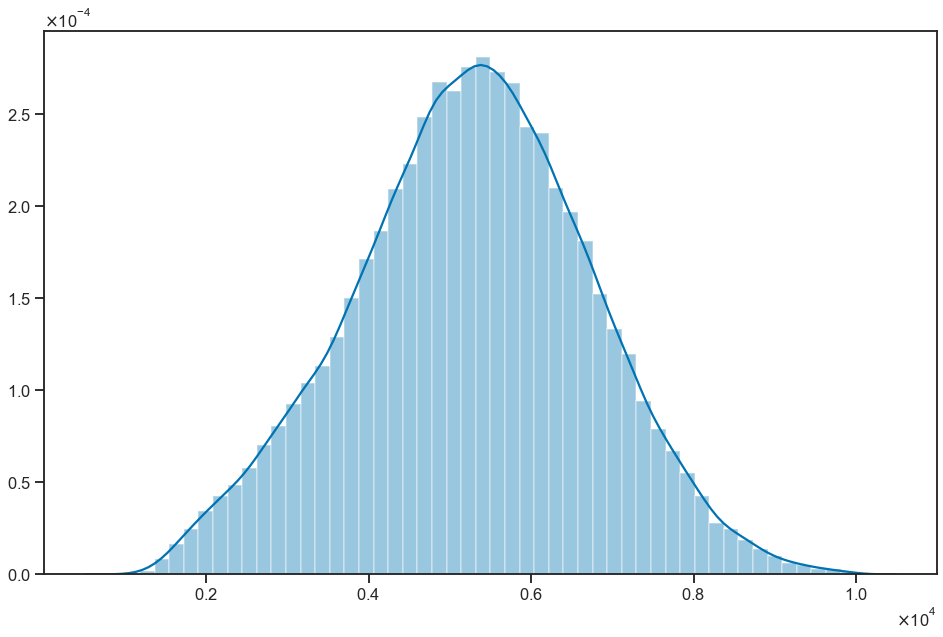

In [5]:
ra = samples['ra']
dec = samples['dec']
distance = samples['luminosity_distance']
sns.distplot(distance)

In [6]:
prior = dict(dec=Cosine(), ra=Uniform(minimum=0, maximum=2*np.pi),
             luminosity_distance=PowerLaw(alpha=2, minimum=1, maximum=15000))

weights = 1 / prior["luminosity_distance"].prob(distance)
draws = np.random.uniform(0, max(weights), weights.shape)
keep = weights > draws
ra_samples = ra[keep]
dec_samples = dec[keep]
distance_samples = distance[keep]

In [7]:
ra_samples = ra
dec_samples = dec
distance_samples = distance

65723

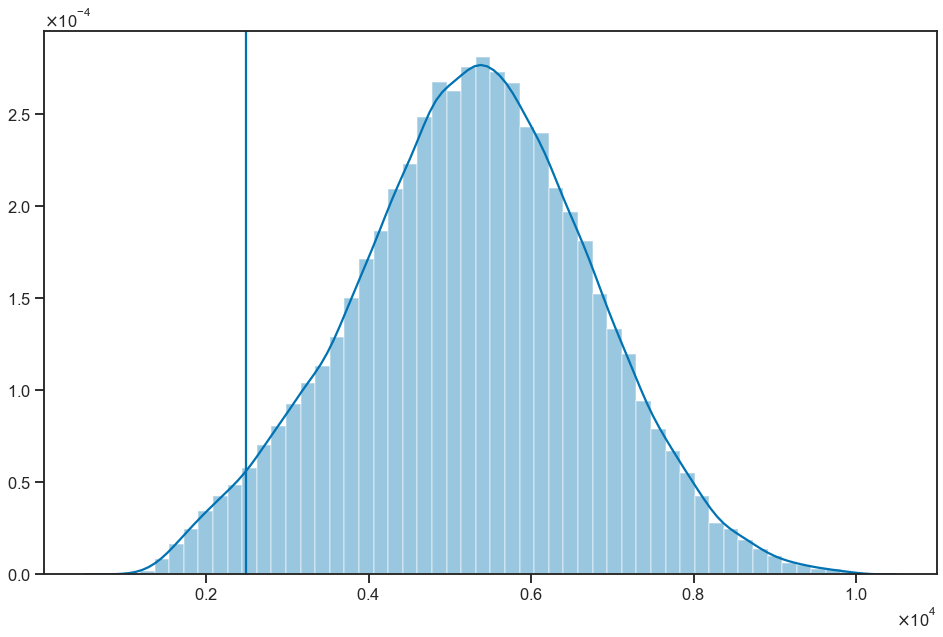

In [8]:
sns.distplot(distance_samples)
plt.axvline(dl)
len(distance_samples)

In [17]:
pts = np.vstack((ra_samples,dec_samples,distance_samples)).T
KDE = ClusteredKDE(pts,max_k=8)

In [24]:
x = np.linspace(100,13000,10000)
ras = np.repeat(ra_c,10000)
decs = np.repeat(dec_c,10000)

pts = np.vstack((ras,decs,x)).T

pdf = KDE(pts)
pdf=pdf/np.sum(pdf)

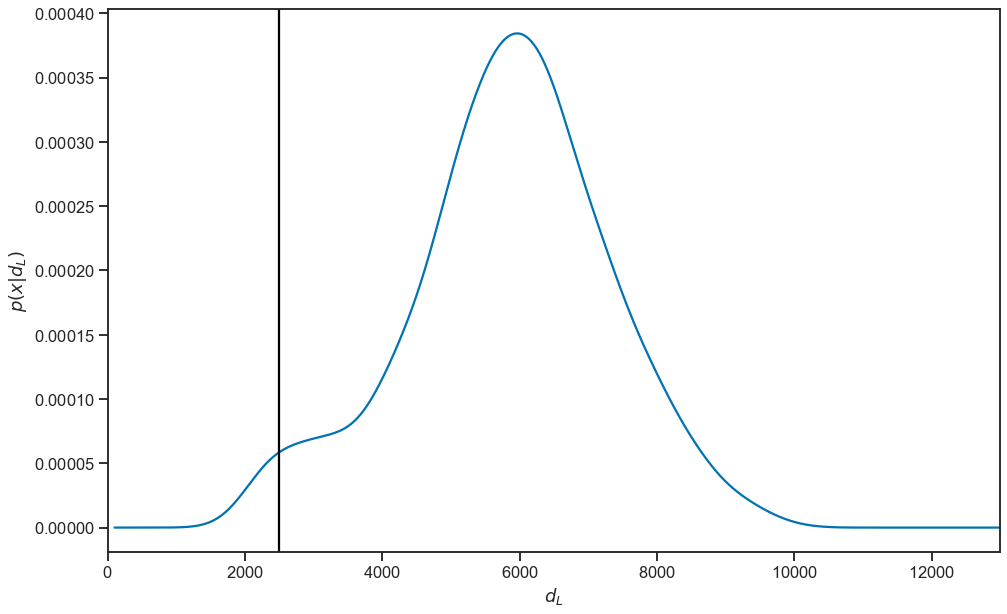

In [25]:
fig, ax = plt.subplots()
plt.plot(x,pdf)
plt.axvline(dl,color='black')
plt.ylabel(r'$p(x|d_L)$')
plt.xlabel(r'$d_L$')
plt.xlim(0,13000)
ax.ticklabel_format(style='plain')


In [16]:
np.savetxt('fit_gdkde_GW190521.dat',np.column_stack([x,pdf]))